In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk.tokenize import sent_tokenize

from num2words import num2words

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

In [5]:
train_df = pd.read_csv('./input/train_5_label.csv', sep = '\t')
feature = ['label', 'tweet']
train_df = train_df[feature]
train_df.rename(columns = {'tweet':'text'}, inplace = True)

train_df.head()

,label,text
0,N,"Portada 'Público', viernes. Fabra al banquillo..."
1,NONE,"Grande! RT @veronicacalderon ""El periodista es..."
2,P+,Gonzalo Altozano tras la presentación de su li...
3,N,"Mañana en Gaceta: TVE, la que pagamos tú y yo,..."
4,NONE,Qué envidia “@mfcastineiras: Pedro mañana x la...


In [6]:
# Checking the dataset for specific words
occurrences = train_df[train_df['text'].str.lower().str.contains(r'\bco\b', na=False)].shape[0]

print(occurrences)

21364


In [7]:
# Checking for null values
train_df.isna().sum()

label    0
text     0
dtype: int64

NONE    21174
P+      20679
N       11282
N+       4555
P        1410
NEU      1305
Name: label, dtype: int64


<Axes: xlabel='label', ylabel='count'>

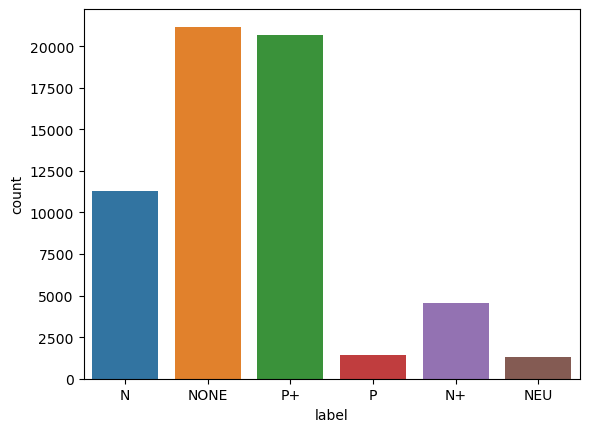

In [8]:
train_df.drop_duplicates(inplace=True, subset="text")

print(train_df.label.value_counts())
sns.countplot(x=train_df['label'], data=train_df)

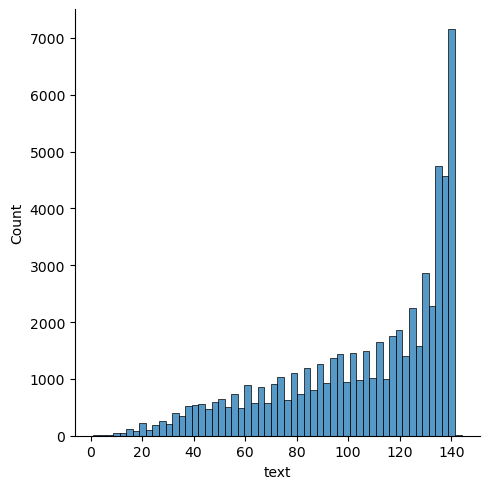

In [9]:
length=train_df['text'].str.len()
sns.displot(length)
plt.show()

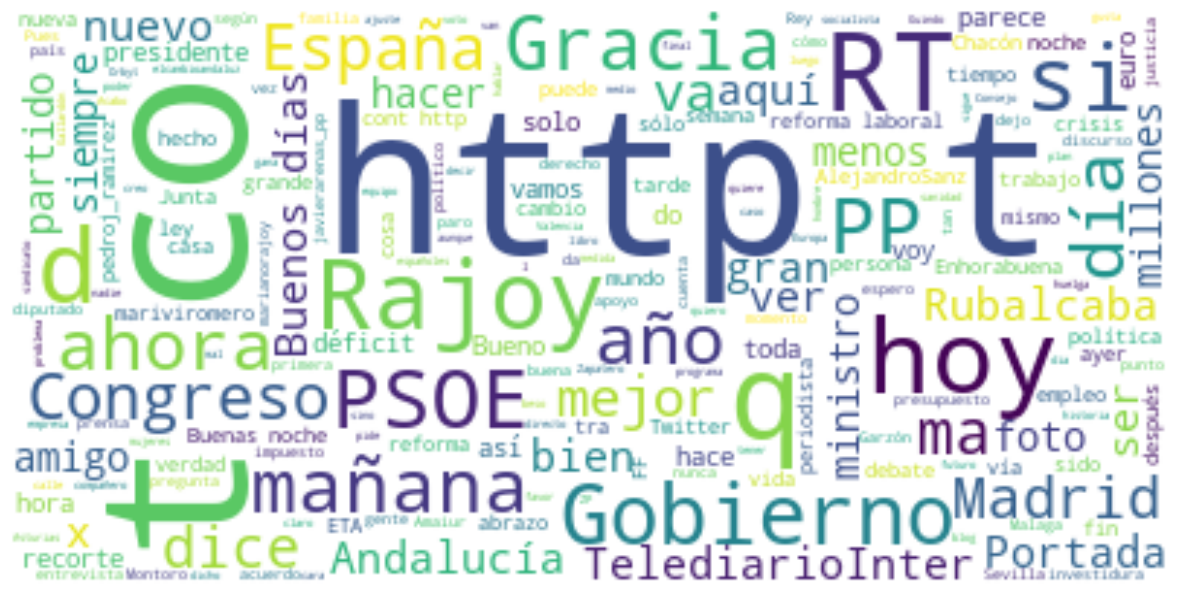

In [10]:
stopwords = stopwords.words('spanish')

text = " ".join(i for i in train_df.text)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [11]:
def remove_stopwords(text):
    stopwords = ["de", "la", "que", "el", "en", 
    "y", "a", "los", "del", "se", "las", "por", 
    "un", "para", "con", "no", "una", "su", "al", 
    "lo", "como", "más", "pero", "sus", "le", "ya", 
    "o", "este", "sí", "porque", "esta", "entre", "cuando", 
    "muy", "sin", "sobre", "también", "me", "hasta", "hay", 
    "donde", "quien", "desde", "todo", "nos", "durante",
    "todos", "uno", "les", "ni", "contra", "otros", "ese", 
    "eso", "ante", "ellos", "e", "esto", "mí", "antes", "algunos", 
    "qué", "unos", "yo", "otro", "otras", "otra", "él", "tanto", "esa", 
    "estos", "mucho", "quienes", "nada", "muchos", "cual", "poco", "ella", 
    "estar", "estas", "algunas", "algo", "nosotros", "mi", "mis", "tú", "te", 
    "ti", "tu", "ellas", "nosotras", "vosotros", "vosotras", "os", "mío", 
    "mía", "míos", "mías", "tuyo", "tuya", "tuyos", "tuyas", "si", "suyo", 
    "suya", "suyos", "suyas", "nuestro", "nuestra", "nuestros", "nuestras", 
    "vuestro", "vuestra", "vuestros", "vuestras", "es", "esos", "esas", "estoy", 
    "estás", "está", "estamos", "estáis", "están", "esté", "estés", "estemos", 
    "estéis", "estén", "estaré", "estarás", "estará", "estaremos", "estaréis", 
    "estarán", "estaría", "estarías", "estaríamos", "estaríais", "estarían", "estaba", 
    "estabas", "estábamos", "estabais", "estaban", "estuve", "estuviste", 
    "estuvo", "estuvimos", "estuvisteis", "estuvieron", "estuviera", "x"]
    
    # split the text into words
    words = re.findall(r'\b\w+\b', text)
    # remove stopwords
    filtered_words = [word for word in words if word.lower() not in stopwords]
    # join the filtered words back into a text
    filtered_text = " ".join(filtered_words)
    return filtered_text

In [12]:
def clean(text):
    #Uncapitalizing words
    clean_text = text.lower()
    
    #Remove links
    clean_text = re.sub(r"https\S+", "", clean_text)         
    clean_text = re.sub(r'((www.[^s]+)|(https?://[^s]+))','',clean_text)         
    clean_text = re.sub(r'http\S+', '', clean_text)         
    clean_text = re.sub(r'https?://\S', ' ', clean_text)         
    clean_text = re.sub(r'http?://\S', ' ', clean_text)

    #Remove users/hashtags
    clean_text = re.sub("@[A-Za-z0-9_]+","", clean_text)
    clean_text = re.sub("#[A-Za-z0-9_]+","", clean_text)

    clean_text = re.sub('[()¡¿!?]','',clean_text)

    #Remove punctuation
    punctuation = string.punctuation
    trans = str.maketrans('', '', punctuation)
    clean_text = clean_text.translate(trans)

    #Remove accents
    a,b = 'àäáéèëíìïòöóùúüÁÉÍÓÚÜ','aaaeeeiiiooouuuAEIOUU'
    trans = str.maketrans(a,b)
    clean_text = clean_text.translate(trans)
    clean_text = re.sub("[^a-z0-9ñáéíóúü]"," ", clean_text)
    #clean_text = re.sub("[^a-z0-9ñ]"," ", clean_text)

    #Remove recurring words with low semantic value (rt, q, d...)
    clean_text = re.sub(r'\b(rt|mas|co|http|cont|ma|p|t|q|d|s)\b', '', clean_text)
    
    #Transform numerical values into words
    clean_text = ' '.join([num2words(int(word), lang='es') if word.isdigit() else word for word in clean_text.split()])

    #Remove repeated letters, except l, r and c (which can repeat in Spanish)
    clean_text = re.sub(r"(?i)([a-z])(?<![rlcs])\1+", r"\1", clean_text)
    
    #Remove emojis
    clean_text = re.sub(r'[\U0001f600-\U0001f64f]', '', clean_text)

    #Remove extra-spaces
    clean_text = re.sub(r'\s+', ' ', clean_text)

    clean_text = remove_stopwords(clean_text)

    clean_text = clean_text.strip()

    return clean_text

In [13]:
#Remove sentences that get repeated with nltk
#clean_text = remove_duplicate_sentences(train)

for i in range(0,4):
    print(clean(train_df.iloc[i]['text']))

portada publico viernes fabra banquillo orden supremo wikileaks retrata ciento sesenta empresas espias
grande periodista alguien quiere contar realidad vive via
gonzalo altozano tras presentacion libro ciento españoles dios divertido emocionante brillante
mañana gaceta tve pagamos culpa becaria falsa informacion cierre


In [14]:
train_df["cleaned_text"] = train_df["text"].apply(clean)

#train["cleaned_text"] = train["cleaned_text"].apply(remove_duplicate_sentences)

# Create a new dataframe with the cleaned tweets
cleaned_df = train_df[["label", "cleaned_text"]]
print(cleaned_df.head())

  label                                       cleaned_text
0     N  portada publico viernes fabra banquillo orden ...
1  NONE  grande periodista alguien quiere contar realid...
2    P+  gonzalo altozano tras presentacion libro cient...
3     N  mañana gaceta tve pagamos culpa becaria falsa ...
4  NONE  envidia pedro mañana mañana voy paris almendra...


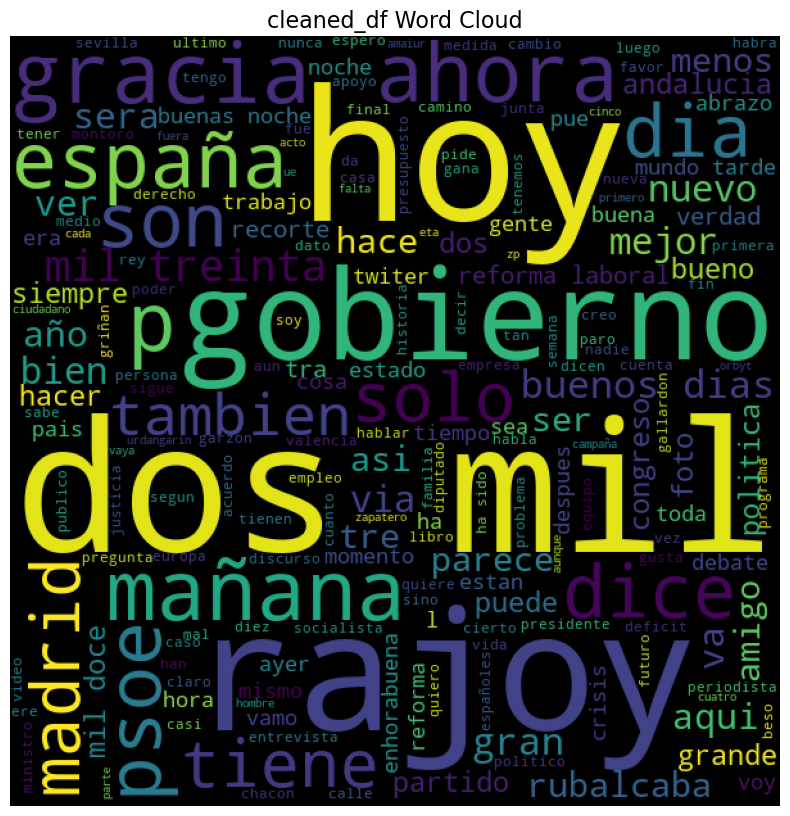

In [15]:
#World Cloud 
def plot_cloud(wordcloud, temp): 
    plt.figure(figsize=(10, 10)) 
    plt.title(temp+' Word Cloud', size = 16) 
    plt.imshow(wordcloud)      
    # No axis details 
    plt.axis("off")

temp_text = ' '.join([sentence for sentence in cleaned_df.cleaned_text])
wordcloud = WordCloud(width = 600, height = 600).generate(temp_text)
plot_cloud(wordcloud, "cleaned_df")

In [16]:
cleaned_df.to_csv("input/cleaned_dataset.csv", index=False)